# Module 2 - Final Project - SQL and Statistical Significance

## Importing Required Libraries and Querying SQL DB

In [59]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from statsmodels.formula.api import ols
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import warnings 
from IPython.core.interactiveshell import InteractiveShell

conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
'''))

In [60]:
warnings.simplefilter('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [61]:
print(table_names)

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [62]:
sql_comm = []
for i in range(0, len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

# Reading in SQL Tables into Pandas Dataframes
employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)
orders = pd.read_sql_query('''SELECT * FROM [Order]''', conn)

# Product Pricing and Customer Incentives

## Question 1
__Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?__

$H_{o}$: The average quantity of product ordered is the same for normally priced orders and those with a discount

$H_{a}$: The average quantity of product ordered is not the same for normally prices orders and those with a discount, the quantity is either higher or lower

__Control Group__: Orders without any discounts applied, full price products sold
<br>
__Experimental Group__: Orders with discounts applied, products sold at lower than retail price

### Data Wrangling
Table: Order Details

In [455]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_bin
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [63]:
order_details[['Quantity', 'Discount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


### Question 1a
<br>
Our primary question to address is whether discounting of products will impact the amount of product that Company X is selling. This is an important question to ask for sales, marketing, and product management teams in order for them to optimize their messaging, customer loyalty, and most importantly...the bottom line. If we are able to answer this question and determine at what levels of discounting results in the greatest uptick of customer orders/product deliveries, we can generate a larger profit and continue to grow our business.

__How:__ test our hypotheses with a two-tail test accounting for either an increase or decrease in products ordered as a result of discounts applied to said products.
<br>
__Table:__ order_details
<br>
__Features:__ Quantity, Discount

__Control Group__: Orders without discount
<br>
__Experimental Group:__ Discounted product orders

In [64]:
order_details.Discount.value_counts().head()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
Name: Discount, dtype: int64

In [65]:
order_details[['Quantity', 'Discount']].describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [66]:
order_details['Discount_bin'] = order_details['Discount'].apply(lambda x: 1 if x > 0 else 0)

<BarContainer object of 2 artists>

Text(1, 10, '21.72')

Text(0, 10, '27.11')

Text(0, 0.5, 'Average Quantity')

Text(0.5, 1.0, 'Average Quantity of Product Per Order: Discount vs No Discount')

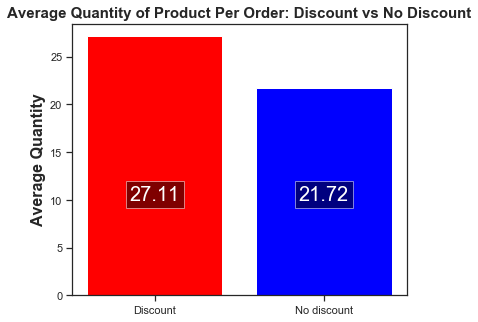

In [457]:
X = ['Discount', 'No discount']
y = [order_details['Quantity'][order_details['Discount_bin'] == 1].mean(),
order_details['Quantity'][order_details['Discount_bin'] == 0].mean()]
plt.bar(X, y, color=('red', 'blue'))
plt.text(s=round(y[1],2), x=1, y=10, color='w', horizontalalignment='center', size=20, 
         bbox=dict(facecolor='black', alpha=0.5))
plt.text(s=round(y[0],2), x=0, y=10, color='w', horizontalalignment='center', size=20, 
         bbox=dict(facecolor='black', alpha=0.5))
plt.ylabel('Average Quantity', fontsize=16, fontweight='bold')
plt.title('Average Quantity of Product Per Order: Discount vs No Discount', fontsize=15, fontweight='bold')

In [68]:
discount_control_group = order_details[order_details.Discount_bin == 0].Quantity
discount_experimental_group = order_details[order_details.Discount_bin == 1].Quantity

__Variance__

In [69]:
print('Control Group Variance:', discount_control_group.var())
print('Experimental Group Variance:', discount_experimental_group.var())
print('Difference', abs(discount_control_group.var() - discount_experimental_group.var()))

Control Group Variance: 306.51232768588454
Experimental Group Variance: 431.45268788690146
Difference 124.94036020101692


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Quantity Distribution of Products Sold')

Text(0.5, 0, 'Quantity of Product')

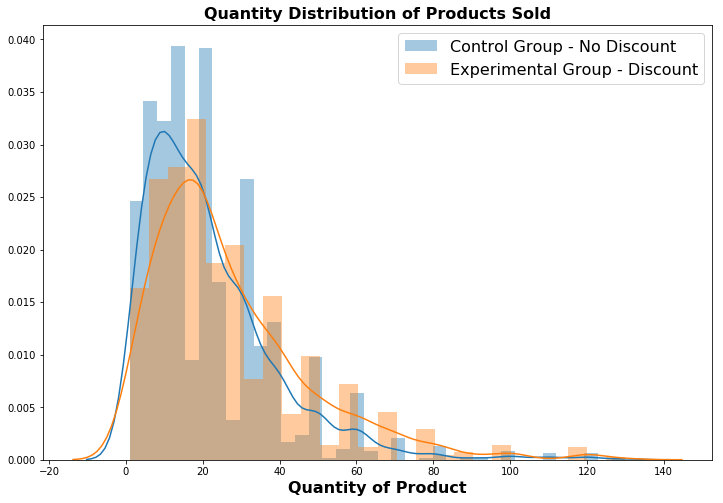

In [71]:
plt.figure(figsize=(12,8))
sns.distplot(discount_control_group, label='Control Group - No Discount')
sns.distplot(discount_experimental_group, label='Experimental Group - Discount')
plt.title('Quantity Distribution of Products Sold', fontsize=16, fontweight='bold')
plt.xlabel('Quantity of Product', fontsize=16, fontweight='bold')
plt.legend(fontsize=16)

__Distribution Analysis__

The above distribution plot shows right skewedness for both the control and experimental group (no discount and discounted product orders). This data differs from a Gaussian distribution, so we will need to decide on an approach to remediate. 

### Normality Test - Two-tailed - Statsmodels Normal Test

In [72]:
print('Normality of Control Group', stats.normaltest(discount_control_group))
print('Normality of Experimental Group', stats.normaltest(discount_experimental_group))

Normality of Control Group NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of Experimental Group NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

We saw above in the distributions that there is a difference between the two means of the control and experimental groups. Let's calculate that difference to determine the effect size of this data.

__Cohen's D - determining effect size__

- -1.0: Perfect negative relationship
- -0.7: Strong negative relationship
- -0.5: Moderate negative relationship
- -0.3: Weak negative relationship
- 0.0: No relationship
- 0.3: Weak positive relationship
- 0.5: Moderate positive relationship
- 0.7: Strong positive relationship
- 1.0: Perfect positive relationship

In [73]:
def Cohens_d(group1, group2):
    
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    pooled_var = (n1 * var1) + (n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    return d

print("Cohen's d:", Cohens_d(np.array(discount_experimental_group), np.array(discount_control_group)))

Cohen's d: 0.008974519957357523


This small effect size of 0.008 indicates

__Welch's T-Test__

Welch's T-Tests can be used regardless of the sample sizes or variances of the control and experiemental groups because it does not assume equal sample size or variance.

In [74]:
def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = a.mean() - b.mean()  
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return numerator/denominator

welch_t(discount_control_group, discount_experimental_group)

-6.239069142123973

Result: -6.239

In [75]:
def welch_df(a, b):
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(discount_control_group, discount_experimental_group)

1561.7678231942148

Now we have a t-value and variance value that we can use to calculate a p-value.

P-value: The probability of obtaining a test statistic at least as extreme as the one we observed if the null hypothesis is true

#### Create a new Sample Distribution

In [76]:
# create a random sample list
def create_sample(df, n):
    sample = []
    while len(sample) < n:
        x = np.random.choice(df)
        sample.append(x)
    return sample
# use random sample list to create a sample distribution in a dataframe
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) < dist_size:
        sample = create_sample(df, n)
        sample_mean = sum(sample)/len(sample)
        sample_dist.append(sample_mean)
    return sample_dist

In [77]:
control_sample = create_sample_distribution(discount_control_group)
experimental_sample = create_sample_distribution(discount_experimental_group)

__Sample Variance__

In [78]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 0.582986557404
Experimental Group Variance: 0.847682324864
Difference 0.26469576746


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Quantity Sample Distribution of Products Sold')

Text(0.5, 0, 'Quantity of Product')

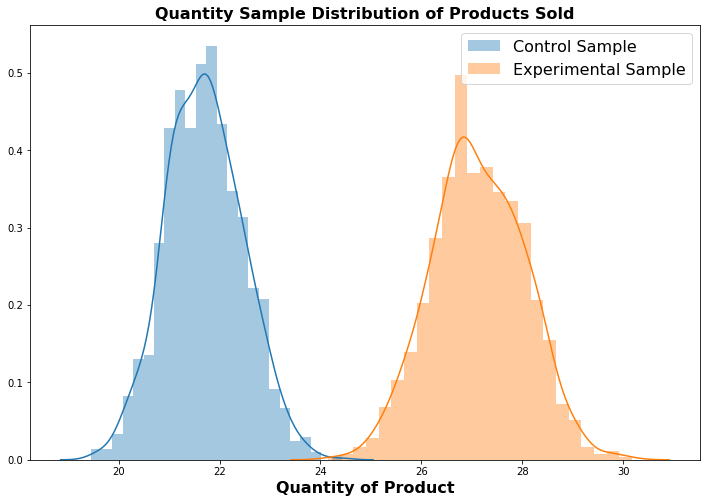

In [79]:
plt.figure(figsize=(12,8))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Quantity Sample Distribution of Products Sold', fontsize=16, fontweight='bold')
plt.xlabel('Quantity of Product', fontsize=16, fontweight='bold')
plt.legend(fontsize=16)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions. Now there is also a significant difference between the two means of the group but similar levels of variance.

In [440]:
p = stats.ttest_ind(control_sample, experimental_sample)[1]
p

0.0

__Conclusion:__ Based on this p-value, we can reject the null hypothesis, the average quantity of product ordered is the same for normally priced orders and those with a discount.

Now, we have answered the first part of question 1, _'Do discounts have a statistically significant effect on the number of products customers order?'_ But we now need to focus on part two, _'If so, at what level(s) of discount?'_


<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Discount Levels for Quantity of Products Sold')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Quantity')

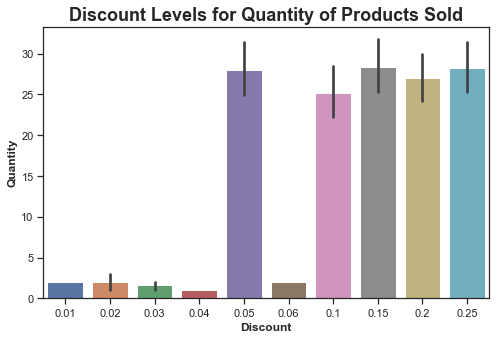

In [258]:
plt.figure(figsize=(8,5))
sns.barplot(discount.Discount, discount.Quantity)
plt.title('Discount Levels for Quantity of Products Sold', fontweight='bold', fontsize=18)
plt.xlabel('Discount', fontweight='bold', fontsize=12)
plt.ylabel('Quantity', fontweight='bold', fontsize=12)

We can see from the visualization above that 0.05, 0.1, 0.15, 0.2, and 0.25 are the most frequently used discount levels for orders that are captured in our data. Let's focus on those discount levels as we see similar levels of quantity for each. we need to run statistical significance tests to validate what we see above.

In [83]:
no_discount = order_details[order_details.Discount == 0]
discount = order_details[order_details.Discount > 0]

In [84]:
p_five = stats.ttest_ind(no_discount.Quantity, discount[discount.Discount == 0.05].Quantity)[1]
p_ten = stats.ttest_ind(no_discount.Quantity, discount[discount.Discount == 0.10].Quantity)[1]
p_fifteen = stats.ttest_ind(no_discount.Quantity, discount[discount.Discount == 0.15].Quantity)[1]
p_twenty = stats.ttest_ind(no_discount.Quantity, discount[discount.Discount == 0.20].Quantity)[1]
p_twenty_five = stats.ttest_ind(no_discount.Quantity, discount[discount.Discount == 0.25].Quantity)[1]

print('T-Test P-values')
print('Five Percent:', p_five)
print('Ten Percent:', p_ten)
print('Fifteen Percent:', p_fifteen)
print('Twenty Percent:', p_twenty)
print('Twenty-five Percent:', p_twenty_five)

T-Test P-values
Five Percent: 1.064949724167325e-05
Ten Percent: 0.015500606526440095
Fifteen Percent: 1.1027809944864872e-05
Twenty Percent: 0.00032631258591041463
Twenty-five Percent: 1.780928988051903e-05


__Conclusion__
<br>
All p-values from the T-Tests conducted for each of the major discount levels compared to non-discount orders are below the alpha threshold 0.05. So at each of these discount levels, we can reject the null hypothesis.

---------------------------------------------------------------------------------------------------------------------

### Question 1b: Are some discount levels more effective at increasing the quantity of products sold than others?

Ho: There is no difference in the quantity of products sold between the various discount levels

Ha: Certain discount levels either increase or decrease the number of products sold.

__How:__ test our hypotheses with a two-tail test accounting for either an increase or decrease in products ordered as a result of discounts applied to said products.
<br>
__Table:__ Order Details
<br>
__Features:__ Quantity, Discount

In [85]:
discount_value_counts = pd.DataFrame(order_details.Discount.value_counts())
discount_value_counts = discount_value_counts.reset_index()
discount_value_counts.columns = ['Discount', 'Quantity']
discount_value_counts.head()

,Discount,Quantity
0,0.00,1317
1,0.05,185
2,0.10,173
3,0.20,161
4,0.15,157


Text(0.5, 1.0, 'Discount Levels')

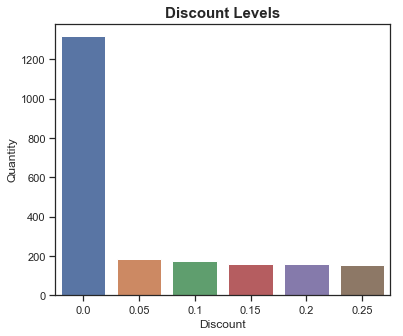

In [444]:
discount_value_counts_sig = discount_value_counts[discount_value_counts.Quantity > 10]
sns.barplot(discount_value_counts_sig.Discount, discount_value_counts_sig.Quantity)
plt.title('Discount Levels', fontweight='bold', fontsize=15)

Text(0.5, 1.0, 'Discount Levels')

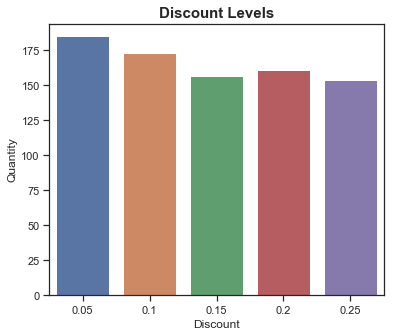

In [445]:
discount_value_counts_discount = discount_value_counts_sig[discount_value_counts_sig.Quantity < 1000]
sns.barplot(discount_value_counts_discount.Discount, discount_value_counts_discount.Quantity)
plt.title('Discount Levels', fontweight='bold', fontsize=15)

In [88]:
five_percent = order_details[order_details.Discount == 0.05]
ten_percent = order_details[order_details.Discount == 0.10]
twenty_percent = order_details[order_details.Discount == 0.20]
fifteen_percent = order_details[order_details.Discount == 0.15]
twenty_five_percent = order_details[order_details.Discount == 0.25]
three_percent = order_details[order_details.Discount == 0.03]
two_percent = order_details[order_details.Discount == 0.02]
one_percent = order_details[order_details.Discount == 0.01]
four_percent = order_details[order_details.Discount == 0.04]
six_percent = order_details[order_details.Discount == 0.06]

In [89]:
p_five_percent = stats.ttest_ind(no_discount.Quantity, five_percent.Discount)[1]
p_ten_percent = stats.ttest_ind(no_discount.Quantity, ten_percent.Discount)[1]
p_twenty_percent = stats.ttest_ind(no_discount.Quantity, twenty_percent.Discount)[1]
p_fifteen_percent = stats.ttest_ind(no_discount.Quantity, fifteen_percent.Discount)[1]
p_twenty_five_percent = stats.ttest_ind(no_discount.Quantity, twenty_five_percent.Discount)[1]
p_three_percent = stats.ttest_ind(no_discount.Quantity, three_percent.Discount)[1]
p_two_percent = stats.ttest_ind(no_discount.Quantity, two_percent.Discount)[1]
p_one_percent = stats.ttest_ind(no_discount.Quantity, one_percent.Discount)[1]
p_four_percent = stats.ttest_ind(no_discount.Quantity, four_percent.Discount)[1]

In [90]:
print("5% discount p-value:", p_five_percent)
print("10% discount p-value:", p_ten_percent)
print("20% discount p-value:", p_twenty_percent)
print("15% discount p-value:", p_fifteen_percent)
print("25% discount p-value:", p_twenty_five_percent)
print("3% discount p-value:", p_three_percent)
print("2% discount p-value:", p_two_percent)
print("1% discount p-value:", p_one_percent)
print("4% discount p-value:", p_four_percent)

5% discount p-value: 2.4607090564337383e-58
10% discount p-value: 1.0842369788850847e-54
20% discount p-value: 7.795067824387305e-51
15% discount p-value: 6.706989688545884e-50
25% discount p-value: 1.2452932381934561e-48
3% discount p-value: 0.0321709141749375
2% discount p-value: 0.08003620100526726
1% discount p-value: nan
4% discount p-value: nan


With the exception of 2%, 1%, and 4%, all discount level p-values fall below the alpha threshold of 0.05. This indicates that we can reject the null hypothesis that at those levels of discount, a different amount of product is sold.

-----------------

# Evaluating Our Sales Team

## Question 2a
__Do the members of our sales team perform equally in terms of the quantity of products sold? How about total sales?__

$H_{o}$: All nine members of the sales team have equal performance in terms of selling products, measured by quantity.

$H_{a}$: Certain members of the sales team perform better and some perform worse than the rest of the team resulting in more or fewer products sold.

__How:__ Test our hypotheses with a two-tail test accounting for a difference in number of products sold amongst the 9 employees on the sales team.
<br>
__Tables:__ Employees, Orders, Order Details, Products
<br>
__Features:__ Quantity, EmployeeId_1, EmployeeId_2, EmployeeId_3, EmployeeId_4, EmployeeId_5, EmployeeId_6, EmployeeId_7, EmployeeId_8, EmployeeId_9

### Data Wrangling
Consolidating data from Employees, Orders, Order Details, and Products tables

Altering column names to match primary keys for related tables

In [93]:
employees.columns = ['EmployeeId', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate',
       'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country',
       'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath']

In [94]:
orders.columns = ['OrderId', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']

In [95]:
products.columns = ['ProductId', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued']

Merge Employees, Orders, Order Details, and Products

In [96]:
employees_orders = pd.merge(employees,
                           orders,
                           on='EmployeeId')
employees_orders_order_details = pd.merge(employees_orders,
                                         order_details,
                                         on='OrderId')
employees_orders_order_details_products = pd.merge(employees_orders_order_details,
                                                  products,
                                                  on=['ProductId', 'UnitPrice'])

Calculate Total Sale for all orders by multiplying the unit price by quantity sold and subtracting the % discount. Then create a new feature Total_Sale to capture that value for each order.

In [97]:
employees_orders_order_details_products['Total_Sale'] = (employees_orders_order_details_products.UnitPrice 
* employees_orders_order_details_products.Quantity * (1-employees_orders_order_details_products.Discount))

Use one-hot encoding for all of the EmployeeIds in order to convert the categorical feature into a numerical feature to use with our ANOVA Tables.

In [98]:
one_hot_employeeId = (pd.get_dummies(employees_orders_order_details_products, 
                                      columns = ["EmployeeId"]))

In [331]:
print('Janet: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_3 == 1].Total_Sale), 2))
print('Nancy: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_1 == 1].Total_Sale), 2))
print('Margaret: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_4 == 1].Total_Sale), 2))
print('Andrew: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_2 == 1].Total_Sale), 2))
print('Robert: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_7 == 1].Total_Sale), 2))
print('Laura: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_8 == 1].Total_Sale), 2))
print('Anne: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_9 == 1].Total_Sale), 2))
print('Michael: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_6 == 1].Total_Sale), 2))
print('Steven: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_5 == 1].Total_Sale), 2))

Janet: $ 154666.63
Nancy: $ 141941.01
Margaret: $ 140336.79
Andrew: $ 137291.92
Robert: $ 88825.14
Laura: $ 85937.84
Anne: $ 64941.57
Michael: $ 53371.08
Steven: $ 48061.96


In [332]:
print('Janet:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_3 == 1].Quantity))
print('Nancy:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_1 == 1].Quantity))
print('Margaret:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_4 == 1].Quantity))
print('Andrew:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_2 == 1].Quantity))
print('Robert:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_7 == 1].Quantity))
print('Laura:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_8 == 1].Quantity))
print('Anne:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_9 == 1].Quantity))
print('Michael:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_6 == 1].Quantity))
print('Steven:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_5 == 1].Quantity))

Janet: 5661
Nancy: 5445
Margaret: 5767
Andrew: 4553
Robert: 3501
Laura: 3980
Anne: 1884
Michael: 2308
Steven: 2075


In [347]:
emp_names_array = ['Janet', 'Nancy', 'Margaret', 'Andrew', 'Robert', 'Laura', 'Anne', 'Michael', 'Steven']
emp_total_sale_array = [154666.63, 141941.01, 140336.79, 137291.92, 88825.14, 85937.84, 64941.57, 53371.08, 48061.96]
emp_total_quant_array = [5661, 5445, 5767, 4553, 3501, 3980, 1884, 2308, 2075]

In [373]:
emp_dictionary_2 = dict(zip(emp_names_array, emp_total_quant_array))
emp_dictionary = dict(zip(emp_names_array, emp_total_sale_array))

In [372]:
df_employees_sales_quant_1 = pd.DataFrame.from_dict(emp_dictionary_2, orient='index').reset_index()
df_employees_sales_quant_1.columns = ['Name', 'Total_Products_Sold']

In [371]:
df_employees_sales_quant = pd.DataFrame.from_dict(emp_dictionary, orient='index').reset_index()
df_employees_sales_quant.columns = ['Name', 'Total_Sale']

In [370]:
combined_df_employees_quant_sale = pd.merge(df_employees_sales_quant_1, df_employees_sales_quant, on='Name')

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Employeee Performance: Total Products Sold')

Text(0.5, 0, 'Name')

Text(0, 0.5, 'Total Products Sold')

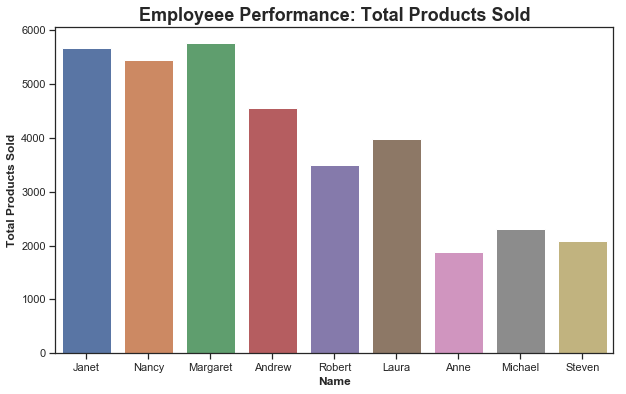

In [369]:
plt.figure(figsize=(10,6))
sns.barplot(combined_df_employees_quant_sale.Name, combined_df_employees_quant_sale.Total_Products_Sold)
plt.title('Employeee Performance: Total Products Sold', fontsize=18, fontweight='bold')
plt.xlabel('Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Products Sold', fontsize=12, fontweight='bold')

__Visualization Analysis__
<br>We can clearly see from the graph above that there are differences between each employee's amount of product sold. Janet, Nancy, and Margaret are the top three sales people generating the largest volume of products sold, all above 5000 units. While we see Anne, Michael, and Steven at the bottom.

__ANOVA Table__

In [99]:
formula = "Quantity ~ C(EmployeeId_1) + C(EmployeeId_2) + C(EmployeeId_3) + C(EmployeeId_4) + C(EmployeeId_5) + C(EmployeeId_6)\
+ C(EmployeeId_7) + C(EmployeeId_8) + C(EmployeeId_9)"
           
lm = ols(formula, one_hot_employeeId).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                        sum_sq      df          F    PR(>F)
C(EmployeeId_1)     124.127133     1.0   0.333205  0.563865
C(EmployeeId_2)    2609.367032     1.0   7.004538  0.008216
C(EmployeeId_3)    3815.342297     1.0  10.241836  0.001402
C(EmployeeId_4)      68.158204     1.0   0.182963  0.668901
C(EmployeeId_5)    1571.298127     1.0   4.217964  0.040173
C(EmployeeId_6)     135.056642     1.0   0.362544  0.547189
C(EmployeeId_7)    5379.028249     1.0  14.439366  0.000151
C(EmployeeId_8)    1090.625367     1.0   2.927655  0.087282
C(EmployeeId_9)      80.919383     1.0   0.217219  0.641236
Residual         554317.557745  1488.0        NaN       NaN


__Conclusion__

Based on the above ANOVA test, we see varied results among the set of employees. EmployeeId 2, 3, 5, and 7 (Andrew, Janet, Steven, and Robert) all resulted in p-values below the alpha threshold of 0.05. So the probability that this data is a result of random circumstance (and we should accept the null hypothesis) is less than 5%. Therefore, we can conclude that their quantities of products sold are significant, rejecting the null hypothesis and accepting the alternate hypothesis: employee performance varies in terms of quantity of products sold.

------------------------------------------------------

## Question 2b
__Do the members of our sales team perform equally in terms total sales?__

$H_{o}$: All nine members of the sales team have equal performance in terms of selling products, measured by total sale.

$H_{a}$: Certain members of the sales team perform better and some perform worse than the rest of the team resulting in a greater or lesser amount of total products sold.

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the total sale of products sld amongst the 9 employees on the sales team.
<br>
__Tables:__ Employees, Orders, Order Details, Products
<br>
__Features:__ Total_Sale, EmployeeId_1, EmployeeId_2, EmployeeId_3, EmployeeId_4, EmployeeId_5, EmployeeId_6, EmployeeId_7, EmployeeId_8, EmployeeId_9

For total sale, we can take the same approach as we did above comparing employee performance based on the Quantity of products sold, substituting Total_Sale into our ANOVA Table calculation with our one-hot encoded employeeId features.

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Employeee Performance: Total Sale')

Text(0.5, 0, 'Name')

Text(0, 0.5, 'Total Sale')

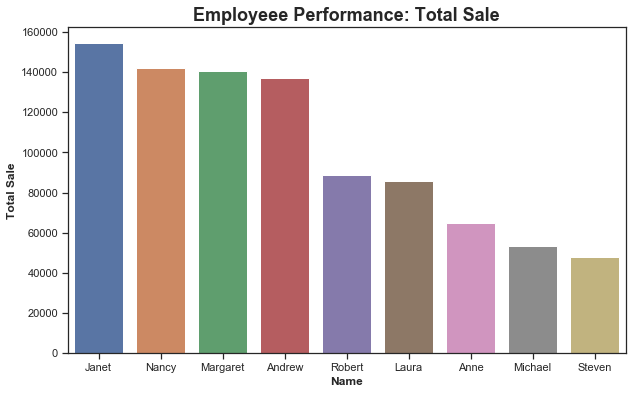

In [367]:
plt.figure(figsize=(10,6))
sns.barplot(combined_df_employees_quant_sale.Name, combined_df_employees_quant_sale.Total_Sale)
plt.title('Employeee Performance: Total Sale', fontsize=18, fontweight='bold')
plt.xlabel('Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Sale', fontsize=12, fontweight='bold')

__Visualization Analysis__
<br>From this bar chart, we again clearly see that each employee generated different gross profits from their sales orders. Janet, Nancy, and Margaret are again in the top three of total sales generated, all above 130,000 dollars. We again see Anne, Michael, and Steven at the bottom.

__ANOVA Table__

In [100]:
formula = "Total_Sale ~ C(EmployeeId_1) + C(EmployeeId_2) + C(EmployeeId_3) + C(EmployeeId_4) + C(EmployeeId_5) + C(EmployeeId_6)\
+ C(EmployeeId_7) + C(EmployeeId_8) + C(EmployeeId_9)"
           
lm = ols(formula, one_hot_employeeId).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                       sum_sq      df         F    PR(>F)
C(EmployeeId_1)  6.373875e+04     1.0  0.062078  0.803275
C(EmployeeId_2)  7.474497e+06     1.0  7.279800  0.007052
C(EmployeeId_3)  4.250815e+06     1.0  4.140089  0.042056
C(EmployeeId_4)  2.001221e+05     1.0  0.194909  0.658926
C(EmployeeId_5)  8.358050e+04     1.0  0.081403  0.775444
C(EmployeeId_6)  1.021894e+06     1.0  0.995276  0.318619
C(EmployeeId_7)  2.735335e+06     1.0  2.664085  0.102848
C(EmployeeId_8)  3.764771e+05     1.0  0.366671  0.544917
C(EmployeeId_9)  4.277415e+06     1.0  4.165996  0.041419
Residual         1.527796e+09  1488.0       NaN       NaN


__Conclusion__

Based on the above ANOVA test, we again see varied results among the set of employees. This time, EmployeeId 2, 3, and 9 (Andrew, Janet, and Anne) all resulted in p-values below the alpha threshold of 0.05. Therefore, we can conclude that their total sales figures are significant, thus we can reject the null hypothesis that all employees perform equally in terms of amount ($) total sold. These results match what we saw in our visualizations above.

__Quantity vs. Total Sale Performance Comparison__
<br>Our two ANOVA Tests produced different results when comparing employee performance based on quantity of products sold and total sale. Employees 2 and 3 (Andrew and Janet) were the two shared results between the two tests with p-values below the alpha threshold. The deltas we see are with the employee 5 and 7 results: low enough p-values for quantity of products sold but not for total_sale AND employee 9: low enough p-value for total_sale but not for quantity of products sold.

--------

# Customer Buying Trends

## Question 3
__Are reorder levels effective indicators of popular products?__

$H_{o}$: Reorder levels have no impact on the number of customer orders for a particular product.

$H_{a}$: The magnitude of reorders impacts the number of orders for a particular product.

__Hypothesis Testing Type__: Two-Tailed

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the number of customer orders for products based on reorder level.
<br>
__Tables:__ Products, Employees, Customers, Orders, Order Details, Categories
<br>
__Features:__ ReorderLevel, Quantity

__Control Group__: Orders of products with no reorder level
<br>
__Experimental Group__: Positive reorder level products

### Data Wrangling
Tables: Products, Employees, Customers, Orders, Order Details, Categories

In [113]:
products.ReorderLevel.describe()

count    77.000000
mean     12.467532
std      10.931105
min       0.000000
25%       0.000000
50%      10.000000
75%      25.000000
max      30.000000
Name: ReorderLevel, dtype: float64

In [116]:
categories.columns = ['CategoryId', 'CategoryName', 'Description']

In [117]:
employees_orders_order_details_products_categories = pd.merge(employees_orders_order_details_products,
                                                   categories,
                                                   on='CategoryId')

In [118]:
reorder_value_counts = pd.DataFrame(employees_orders_order_details_products_categories.Discount.value_counts())
reorder_value_counts = reorder_value_counts.reset_index()
reorder_value_counts.columns = ['Reorder_Level', 'Quantity']
reorder_value_counts.head()

,Reorder_Level,Quantity
0,0.00,915
1,0.05,136
2,0.25,115
3,0.15,111
4,0.20,107


<Figure size 432x216 with 0 Axes>

Text(0.5, 1.0, 'All Orders: Discounts Applied')

Text(0.5, 0, 'Reorder Level')

Text(0, 0.5, 'Number of Orders')

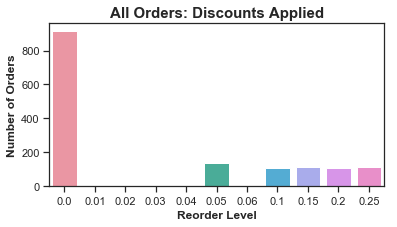

In [450]:
plt.figure(figsize=(6,3))
sns.barplot(reorder_value_counts.Reorder_Level, reorder_value_counts.Quantity)
plt.title('All Orders: Discounts Applied', fontweight='bold', fontsize=15)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=12)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)

In [395]:
high_impact_reorders = reorder_value_counts[reorder_value_counts.Reorder_Level > 0]

In [392]:
experimental_high_impact_products = employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel > 0].Quantity
control_low_impact_products = employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 0].Quantity
reorder_level_high_impact = employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel > 0].ReorderLevel

<Figure size 432x216 with 0 Axes>

Text(0.5, 1.0, 'Discounts Applied to Orders')

Text(0.5, 0, 'Reorder Level')

Text(0, 0.5, 'Number of Orders')

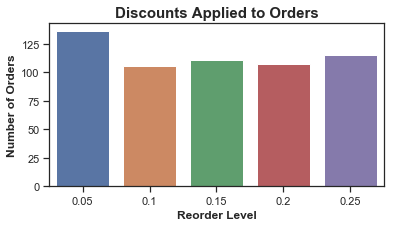

In [447]:
plt.figure(figsize=(6,3))
sns.barplot((high_impact_reorders[high_impact_reorders.Quantity > 25].Reorder_Level), 
            (high_impact_reorders[high_impact_reorders.Quantity > 25].Quantity))
plt.title('Discounts Applied to Orders', fontweight='bold', fontsize=15)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=12)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)

__Variance__

In [458]:
print('Control Group Variance:', experimental_high_impact_products.var())
print('Experimental Group Variance:', experimental_high_impact_products.var())
print('Difference', abs(control_low_impact_products.var() - experimental_high_impact_products.var()))

Control Group Variance: 369.951954374931
Experimental Group Variance: 369.951954374931
Difference 14.765619127365483


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Reorder Level Sample Distribution')

Text(0.5, 0, 'Reorder Level')

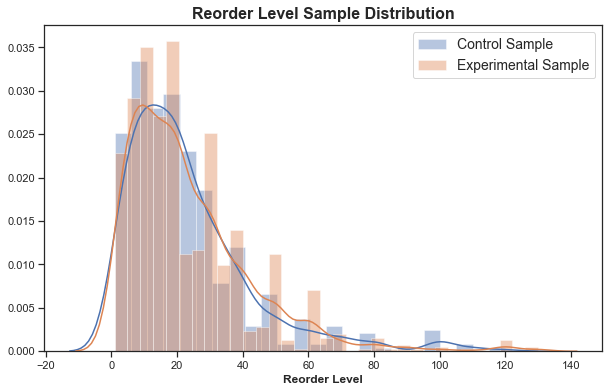

In [454]:
plt.figure(figsize=(10,6))
sns.distplot(control_low_impact_products, label='Control Sample')
sns.distplot(experimental_high_impact_products, label='Experimental Sample')
plt.title('Reorder Level Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Reorder Level', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

### Normality Test - Two-tailed - Statsmodels Normal Test

In [123]:
print('Normality of Control Group', stats.normaltest(control_low_impact_products))
print('Normality of Experimental Group', stats.normaltest(experimental_high_impact_products))

Normality of Control Group NormaltestResult(statistic=201.20025815444595, pvalue=2.041357473034165e-44)
Normality of Experimental Group NormaltestResult(statistic=404.56882747121597, pvalue=1.4092736754417282e-88)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

We saw above in the distributions that there is a difference between the two means of the control and experimental groups. Let's calculate that difference to determine the effect size of this data.

__Cohen's D - determining effect size__

- -1.0: Perfect negative relationship
- -0.7: Strong negative relationship
- -0.5: Moderate negative relationship
- -0.3: Weak negative relationship
- 0.0: No relationship
- 0.3: Weak positive relationship
- 0.5: Moderate positive relationship
- 0.7: Strong positive relationship
- 1.0: Perfect positive relationship

In [124]:
print("Cohen's d:", Cohens_d(np.array(experimental_high_impact_products), np.array(control_low_impact_products)))

Cohen's d: 0.0002621987471826185


__Welch's T-Test__

Welch's T-Tests can be used regardless of the sample sizes or variances of the control and experiemental groups because it does not assume equal sample size or variance.

In [125]:
welch_t(control_low_impact_products, experimental_high_impact_products)

-0.14901620026331674

Result: -0.149

In [126]:
welch_df(control_low_impact_products, experimental_high_impact_products)

949.3806024156935

Now we have a t-value and variance value that we can use to calculate a p-value.

P-value: The probability of obtaining a test statistic at least as extreme as the one we observed if the null hypothesis is true

#### Create a new Sample Distribution

In [127]:
control_sample = create_sample_distribution(control_low_impact_products)
experimental_sample = create_sample_distribution(experimental_high_impact_products)

__Sample Variance__

In [128]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 0.8193033004000001
Experimental Group Variance: 0.7925088537239999
Difference 0.026794446676000172


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Reorder Level Sample Distribution')

Text(0.5, 0, 'Reorder Level')

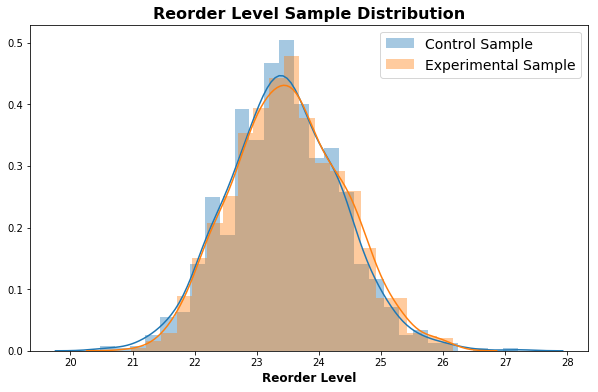

In [129]:
plt.figure(figsize=(10,6))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Reorder Level Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Reorder Level', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions with minimal variance between the two groups (similar means consistent with Cohen's d value of 0.0003)

In [130]:
reordered_products = products[products.ReorderLevel > 0]
no_reorder_products = products[products.ReorderLevel == 0]

reorder_level_p_value = stats.ttest_ind(reordered_products.ReorderLevel, no_reorder_products.ReorderLevel)[1]
reorder_level_p_value

1.8941217981911442e-16

With this low p-value below the alpha threshold of 0.05, we can reject the null hypothesis.

<Figure size 576x288 with 0 Axes>

Text(0.5, 1.0, 'Product Overview: Unit Pricing by Categories')

Text(0, 0.5, 'Category Name')

Text(0.5, 0, 'Unit Price')

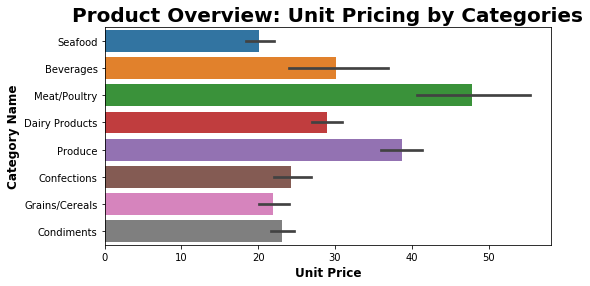

In [131]:
plt.figure(figsize=(8,4))
sns.barplot(employees_orders_order_details_products_categories.UnitPrice, 
            employees_orders_order_details_products_categories.CategoryName)
plt.title('Product Overview: Unit Pricing by Categories', fontweight='bold', fontsize=20)
plt.ylabel('Category Name', fontweight='bold', fontsize=12)
plt.xlabel('Unit Price', fontweight='bold', fontsize=12)

<Figure size 576x288 with 0 Axes>

Text(0.5, 1.0, 'Product Overview: Reorder Levels by Categories')

Text(0, 0.5, 'Category Name')

Text(0.5, 0, 'Reorder Level')

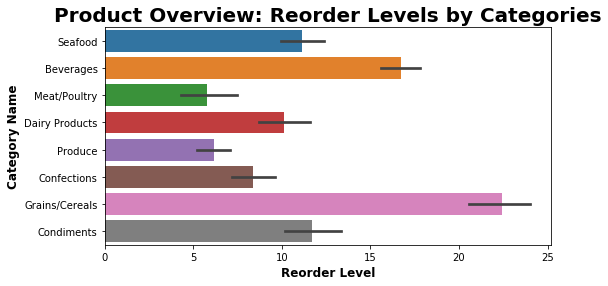

In [132]:
plt.figure(figsize=(8,4))
sns.barplot(employees_orders_order_details_products_categories.ReorderLevel, 
            employees_orders_order_details_products_categories.CategoryName)
plt.title('Product Overview: Reorder Levels by Categories', fontweight='bold', fontsize=20)
plt.ylabel('Category Name', fontweight='bold', fontsize=12)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=12)

---------------------------------------------------------------------------------------------------------------------

# Shipping Efficiency - Freight Costs

## Question 4
__Does the region of the customer versus the region of the supplier impact the shipping prices associated with the freight for these orders?__

$H_{o}$: The region of the customer and supplier have no impact on the price that suppliers pay for shipping products to the customer (freight).

$H_{a}$: The region of the customer and supplier either increases or decreases the shipping cost of products (freight).

__Hypothesis Testing Type__: Two-Tailed

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the number of customer orders for products based on reorder level.
<br>
__Tables:__ Products, Employees, Customers, Orders, Order Details, Categories
<br>
__Features:__ ReorderLevel, Quantity

__Control Group__: Orders between customer and supplier in different regions
<br>
__Experimental Group__: Orders between customer and supplier in the same region

### Data Wrangling
Combining tables to capture Customers, Customer Orders, Order Details, Products, and Suppliers

In [202]:
customers.columns = ['CustomerId', 'CompanyName', 'ContactName', 'ContactTitle', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'Phone', 'Fax']
suppliers.columns = ['SupplierId', 'CompanyName', 'ContactName', 'ContactTitle', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'Phone', 'Fax', 'HomePage']
suppliers.columns = ['SupplierId', 'CompanyName_Supplier', 'ContactName_Supplier', 'ContactTitle_Supplier', 
                     'Address_Supplier', 'City_Supplier', 'Region_Supplier', 'PostalCode_Supplier', 
                     'Country_Supplier', 'Phone_Supplier', 'Fax_Supplier', 'HomePage_Supplier']
customers.columns = ['CustomerId', 'CompanyName_Customer', 'ContactName_Customer', 'ContactTitle_Customer', 'Address_Customer',
       'City_Customer', 'Region_Customer', 'PostalCode_Customer', 'Country_Customer', 'Phone_Customer', 'Fax_Customer']

In [203]:
employees_orders = pd.merge(employees,
                           orders,
                           on='EmployeeId')

In [204]:
employees_orders_order_details = pd.merge(employees_orders,
                                         order_details,
                                         on='OrderId')

In [205]:
employees_orders_order_details_products = pd.merge(employees_orders_order_details,
                                                   products,
                                                   on=['ProductId', 'UnitPrice'])

In [206]:
employees_orders_order_details_products_customers = pd.merge(employees_orders_order_details_products,
        customers,
        on='CustomerId')

In [207]:
employees_orders_order_details_products_customers_suppliers = pd.merge(employees_orders_order_details_products_customers,
        suppliers,
        on='SupplierId')

## Regional Breakdown - Global Customers and Suppliers

In [208]:
employees_orders_order_details_products_customers_suppliers.Region_Customer.unique()

array(['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe'], dtype=object)

In [156]:
employees_orders_order_details_products_customers_suppliers.Region_Customer.value_counts()

Western Europe     505
North America      312
South America      212
British Isles      128
Northern Europe     98
Southern Europe     86
Scandinavia         50
Central America     32
Eastern Europe      14
Name: Region_Customer, dtype: int64

In [158]:
employees_orders_order_details_products_customers_suppliers.Region_Supplier.value_counts()

Western Europe     290
North America      285
British Isles      148
Southern Europe    148
Victoria           112
Northern Europe    109
Scandinavia        105
Eastern Asia        82
NSW                 69
South-East Asia     54
South America       35
Name: Region_Supplier, dtype: int64

In [159]:
counter=0
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    total_region_customers = len(employees_orders_order_details_products_customers_suppliers[
        employees_orders_order_details_products_customers_suppliers.Region_Customer == region])
    total_region_cust_suppliers = len(employees_orders_order_details_products_customers_suppliers[
        (employees_orders_order_details_products_customers_suppliers.Region_Customer == region) &
        (employees_orders_order_details_products_customers_suppliers.Region_Supplier == region)])
    counter = counter + total_region_cust_suppliers
    print('Total Customers in', region, ':', total_region_customers)
    print('Customer and Supplier in', region, ':', total_region_cust_suppliers,)
    print('% Both from ', region, ':', round(total_region_cust_suppliers/total_region_customers, 3))
    print('\n')
print('Total orders where the customer region matches the supplier: ', counter)

Total Customers in Western Europe : 505
Customer and Supplier in Western Europe : 110
% Both from  Western Europe : 0.218


Total Customers in North America : 312
Customer and Supplier in North America : 61
% Both from  North America : 0.196


Total Customers in South America : 212
Customer and Supplier in South America : 7
% Both from  South America : 0.033


Total Customers in Scandinavia : 50
Customer and Supplier in Scandinavia : 3
% Both from  Scandinavia : 0.06


Total Customers in Central America : 32
Customer and Supplier in Central America : 0
% Both from  Central America : 0.0


Total Customers in British Isles : 128
Customer and Supplier in British Isles : 11
% Both from  British Isles : 0.086


Total Customers in Northern Europe : 98
Customer and Supplier in Northern Europe : 10
% Both from  Northern Europe : 0.102


Total Customers in Southern Europe : 86
Customer and Supplier in Southern Europe : 6
% Both from  Southern Europe : 0.07


Total Customers in Eastern Europe : 

In [160]:
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    print(region, '$', round(employees_orders_order_details_products_customers_suppliers[
        employees_orders_order_details_products_customers_suppliers.Region_Customer == region].Freight.mean(), 2))

Western Europe $ 133.64
North America $ 129.83
South America $ 52.17
Scandinavia $ 44.96
Central America $ 50.41
British Isles $ 94.87
Northern Europe $ 123.54
Southern Europe $ 47.44
Eastern Europe $ 32.4


In [161]:
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    print(region, '$', round(employees_orders_order_details_products_customers_suppliers[
        (employees_orders_order_details_products_customers_suppliers.Region_Customer == region) &
        (employees_orders_order_details_products_customers_suppliers.Region_Supplier == region)].Freight.mean(), 2))

Western Europe $ 165.26
North America $ 107.96
South America $ 43.13
Scandinavia $ 17.96
Central America $ nan
British Isles $ 70.91
Northern Europe $ 143.03
Southern Europe $ 57.72
Eastern Europe $ nan


In [162]:
same_region_df_1 = employees_orders_order_details_products_customers_suppliers.copy(deep=True)

In [410]:
same_region_df_1.Region_Customer.unique()

array(['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe'], dtype=object)

In [425]:
region_array = ['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe']
diff_region_array = [133.64, 129.83, 52.17, 44.96, 50.41, 94.87, 123.54, 47.44, 32.4]
same_region_array = [165.26, 107.96, 43.13, 17.96, 0, 70.91, 143.03, 57.72, 0]

In [426]:
reg_dictionary_2 = dict(zip(region_array, diff_region_array))
reg_dictionary = dict(zip(region_array, same_region_array))

In [427]:
df_diff_region_freight = pd.DataFrame.from_dict(reg_dictionary_2, orient='index').reset_index()
df_diff_region_freight.columns = ['Region', 'Different_Region_Freight']

In [428]:
df_same_region_freight = pd.DataFrame.from_dict(reg_dictionary, orient='index').reset_index()
df_same_region_freight.columns = ['Region', 'Same_Region_Freight']

In [429]:
combined_diff_and_same_region_freight = pd.merge(df_diff_region_freight, df_same_region_freight, on='Region')

### Visualizing the Data - Freight Costs within and between global regions

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Global Shipping to Different Regions: Freight Costs')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Freight Cost ($)')

[Text(0, 0, 'Western Europe'),
 Text(0, 0, 'North America'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Scandinavia'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'British Isles'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Eastern Europe')]

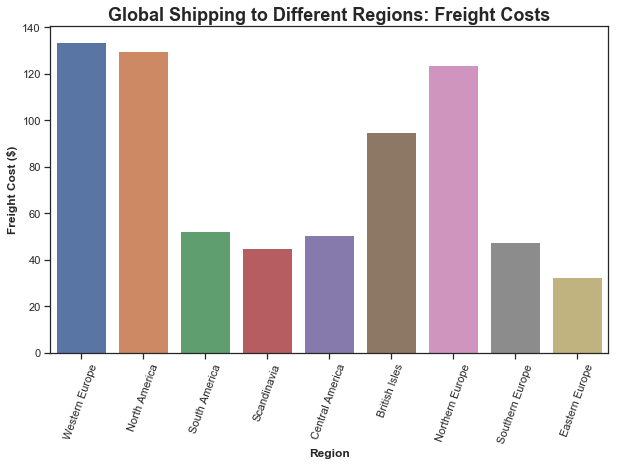

In [435]:
plt.figure(figsize=(10,6))
plot_diff_region = sns.barplot(combined_diff_and_same_region_freight.Region, combined_diff_and_same_region_freight.Different_Region_Freight)
plt.title('Global Shipping to Different Regions: Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Freight Cost ($)', fontsize=12, fontweight='bold')
plot_diff_region.set_xticklabels(plot_diff_region.get_xticklabels(), rotation=70)

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Shipping Within Regions: Freight Costs')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Freight Cost ($)')

[Text(0, 0, 'Western Europe'),
 Text(0, 0, 'North America'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Scandinavia'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'British Isles'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Eastern Europe')]

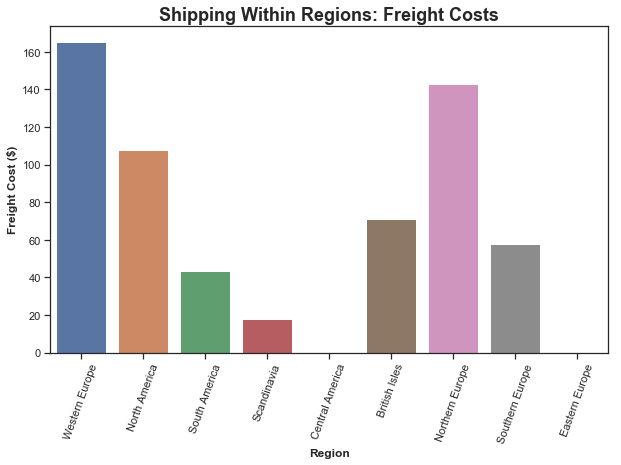

In [434]:
plt.figure(figsize=(10,6))
plot_same_region = sns.barplot(combined_diff_and_same_region_freight.Region, 
                               combined_diff_and_same_region_freight.Same_Region_Freight)
plt.title('Shipping Within Regions: Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Freight Cost ($)', fontsize=12, fontweight='bold')
plot_same_region.set_xticklabels(plot_same_region.get_xticklabels(), rotation=70)

In [163]:
same_region_df_1['Same_Region'] = np.where(same_region_df_1['Region_Customer'] == 
                                           same_region_df_1['Region_Supplier'], 1, 0)

In [215]:
same_region_df_1.Same_Region.value_counts()

0    1229
1     208
Name: Same_Region, dtype: int64

In [224]:
diff_region_control_group = same_region_df_1[same_region_df_1.Same_Region == 0]
same_region_experimental_group = same_region_df_1[same_region_df_1.Same_Region == 1]
diff_region_control_group_freight = diff_region_control_group.Freight
same_region_experimental_group_freight = same_region_experimental_group.Freight

In [386]:
print(diff_region_control_group.Freight.mean())
print(same_region_experimental_group.Freight.mean())

100.91545158665582
133.06134615384616


Interestingly, we see an increase in cost for freight for orders where the customer and supplier hail from the same region. This by itself, does not paint a clear picture as to why. We would need to explore the other conditions of the orders such as size/quantity of orders domestic vs international as well as the types of products in these orders.

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Supplier and Customer Region Freight Costs')

Text(0.5, 0, 'Freight ($)')

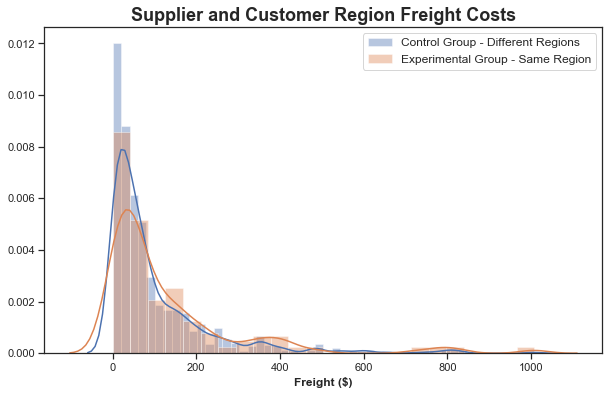

In [225]:
plt.figure(figsize=(10,6))
sns.distplot(diff_region_control_group_freight, label='Control Group - Different Regions')
sns.distplot(same_region_experimental_group_freight, label='Experimental Group - Same Region')
plt.title('Supplier and Customer Region Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Freight ($)', fontsize=12, fontweight='bold')
plt.legend(fontsize=12)

__Distribution Analysis__
<br>The above distribution plot shows heavy right skewedness for both the control and experimental group. We will likely need to explore transformation or resampling in order to fullfill the normality assumption to move forward.

### Normality Test - Two-tailed - Statsmodels Normal Test

In [226]:
print('Normality of Control Group', stats.normaltest(diff_region_control_group_freight))
print('Normality of Experimental Group', stats.normaltest(same_region_experimental_group_freight))

Normality of Control Group NormaltestResult(statistic=782.3457933967768, pvalue=1.3054778085715278e-170)
Normality of Experimental Group NormaltestResult(statistic=134.5411215999535, pvalue=6.092094760649916e-30)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

We saw above in the distributions that there is a small difference between the two means of the control and experimental groups. Let's calculate that difference to determine the effect size of this data.

__Cohen's D - determining effect size__

- -1.0: Perfect negative relationship
- -0.7: Strong negative relationship
- -0.5: Moderate negative relationship
- -0.3: Weak negative relationship
- 0.0: No relationship
- 0.3: Weak positive relationship
- 0.5: Moderate positive relationship
- 0.7: Strong positive relationship
- 1.0: Perfect positive relationship

In [227]:
print("Cohen's d:", Cohens_d(np.array(same_region_experimental_group_freight), 
                             np.array(diff_region_control_group_freight)))

Cohen's d: 0.012351686825689384


There is a very small Cohen's d value for effect size between the control and experimental groups.

__Welch's T-Test__

Welch's T-Tests can be used regardless of the sample sizes or variances of the control and experiemental groups because it does not assume equal sample size or variance.

In [228]:
welch_t(diff_region_control_group_freight, same_region_experimental_group_freight)

-2.4506225349869513

Result: -2.45

In [229]:
welch_df(diff_region_control_group_freight, same_region_experimental_group_freight)

248.4260213957897

Now we have a t-value and variance value that we can use to calculate a p-value.

P-value: The probability of obtaining a test statistic at least as extreme as the one we observed if the null hypothesis is true

#### Create a new Sample Distribution

In [230]:
control_sample = create_sample_distribution(diff_region_control_group_freight)
experimental_sample = create_sample_distribution(same_region_experimental_group_freight)

__Sample Variance__

In [231]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 38.05301235875802
Experimental Group Variance: 64.32305410529773
Difference 26.27004174653971


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Freight Cost: Supplier and Customer Regions')

Text(0.5, 0, 'Freight ($)')

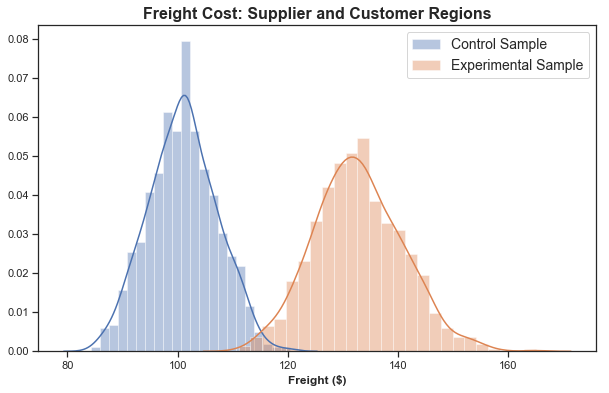

In [235]:
plt.figure(figsize=(10,6))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Freight Cost: Supplier and Customer Regions', fontsize=16, fontweight='bold')
plt.xlabel('Freight ($)', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions with now significant variance between the two groups.

__ANOVA Test__

In [236]:
formula = "Freight ~ C(Same_Region)"
           
lm = ols(formula, same_region_df_1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F    PR(>F)
C(Same_Region)  1.838271e+05     1.0  8.917523  0.002872
Residual        2.958129e+07  1435.0       NaN       NaN


__Conclusion__

Based on the above ANOVA test, we see a p-value within the alpha threshold of 0.05. Thus we can reject the null hypothesis and accept the alternative hypothesis, freight costs will differ between orders that occur within the same region (customer and supplier) vs differing global regions. I actually found that prices are largely higher for orders within the same region, which is interesting because it generally means that the product travels a shorter distance. But as I stated before, there are number of other conditions that will impact freight costs for shipping products worldwide that these results do not yet capture.

---------------------------------------------------------------------------------------------------------------------

-----------

-------------

----------------

# Extra Work

## Understanding products, customer preferences and buying trends

In [209]:
experimental_high_impact_products = employees_orders_order_details_products_customers_suppliers[
    employees_orders_order_details_products_customers_suppliers.ReorderLevel > 0].Quantity
control_low_impact_products = employees_orders_order_details_products_customers_suppliers[
    employees_orders_order_details_products_customers_suppliers.ReorderLevel == 0].Quantity

In [166]:
current_prod = products[products.Discontinued == 0]

In [167]:
current_prod.columns

Index(['ProductId', 'ProductName', 'SupplierId', 'CategoryId',
       'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder',
       'ReorderLevel', 'Discontinued'],
      dtype='object')

In [168]:
current_prod[['ProductName','UnitPrice']].sort_values(by='UnitPrice', ascending=False)

,ProductName,UnitPrice
37,Côte de Blaye,263.50
19,Sir Rodney's Marmalade,81.00
17,Carnarvon Tigers,62.50
58,Raclette Courdavault,55.00
50,Manjimup Dried Apples,53.00
61,Tarte au sucre,49.30
42,Ipoh Coffee,46.00
62,Vegie-spread,43.90
26,Schoggi Schokolade,43.90
7,Northwoods Cranberry Sauce,40.00


### Product Breakdown
 - 77 total products
 - __Most Expensive: Côte de Blaye - 263.50__
      - Product Description: Dry white wine derived from Ugni Blanc, Colombard, Muscadelle, Sauvignon Blanc, and Sémillon grape varieties
      - Country of Origin: France
      - Region: Blaye is a French wine region in Bordeaux, centred on the town of Blaye, producing both red and white wine, plus a small amount of rosé and sparkling wine. It is located on the right bank of the River Gironde, and surrounds Côtes de Bourg.
 - __Least Expensive: Geitost - 2.50__
      - Product Description: Geitost cheese, pronounced as ‘Yay-Toast’, is a farmhouse and creamery, semi-hard cheese. It is the national cheese of Norway!
      - Country of Origin: Norway
 - __Average Unit Price Across All Products Offered - 28.87__

In [ ]:
current_prod[current_prod.UnitPrice > 33.25].sort_values(by='UnitPrice', ascending=False)

In [ ]:
categories[['CategoryId', 'CategoryName']]

In [ ]:
products[products.UnitPrice > 33.25].CategoryId.value_counts()

In [ ]:
plt.barh(products[(current_prod.UnitPrice > 33.25) & (products.Discontinued == 0)].ProductName, 
         products[(current_prod.UnitPrice > 33.25) & (products.Discontinued == 0)].UnitPrice, color='m')
plt.ylabel("Product Name", fontweight='bold', fontsize=14)
plt.xlabel("Unit Price ($)", fontweight='bold', fontsize=14)
plt.title("Available Top Tier Product Breakdown", fontweight='bold', fontsize=20)
plt.show()

## Investigating Product Pricing

In [ ]:
order_details.UnitPrice.describe()

In [170]:
below_average_unit_price = discount[(discount['UnitPrice'] < order_details.UnitPrice.mean()) & discount['UnitPrice'] > 0]

In [171]:
above_average_unit_price = discount[discount['UnitPrice'] > order_details.UnitPrice.mean()]

Let's take a look at how discounts are applied. Are discounts applied more on expensive products or lower priced products?

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Discount Levels based on Unit Price')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Quantity')

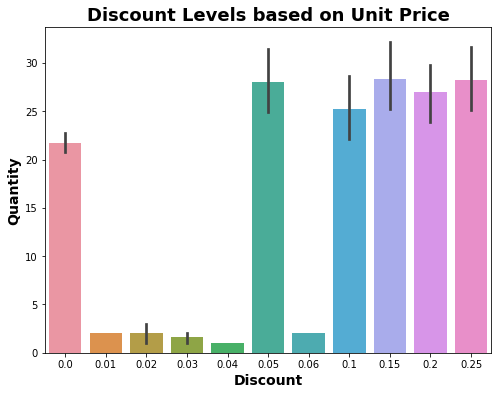

In [172]:
plt.figure(figsize=(8,6))
sns.barplot(order_details.Discount, order_details.Quantity)
plt.title('Discount Levels based on Unit Price', fontweight='bold', fontsize=18)
plt.xlabel('Discount', fontweight='bold', fontsize=14)
plt.ylabel('Quantity', fontweight='bold', fontsize=14)


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Discount Levels based on Unit Price')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Unit Price ($)')

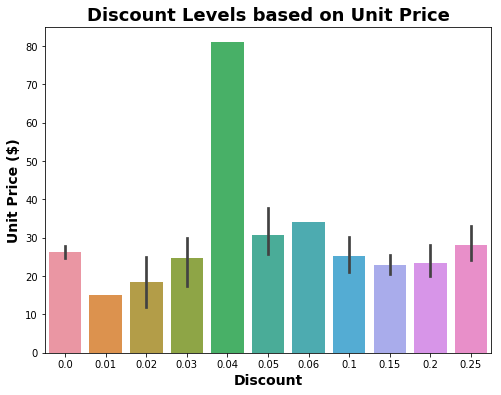

In [173]:
plt.figure(figsize=(8,6))
sns.barplot(order_details.Discount, order_details.UnitPrice)
plt.title('Discount Levels based on Unit Price', fontweight='bold', fontsize=18)
plt.xlabel('Discount', fontweight='bold', fontsize=14)
plt.ylabel('Unit Price ($)', fontweight='bold', fontsize=14)


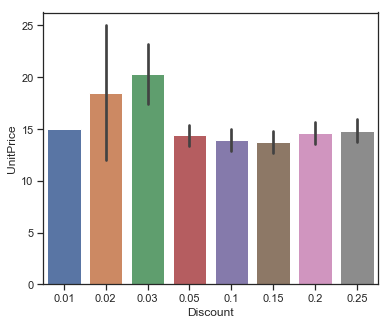

In [174]:
sns.set(rc={'figure.figsize':(6,5)}) 
sns.set_style('ticks')
sns.barplot(below_average_unit_price.Discount, below_average_unit_price.UnitPrice)

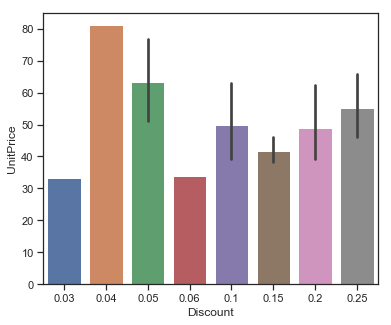

In [175]:
sns.barplot(above_average_unit_price.Discount, above_average_unit_price.UnitPrice)

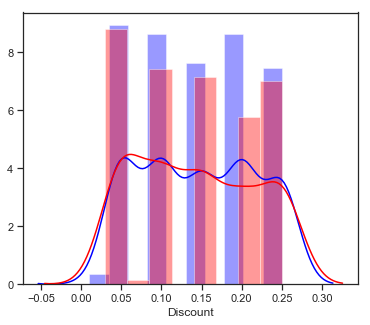

In [176]:
sns.distplot(below_average_unit_price.Discount , color="blue")
sns.distplot(above_average_unit_price.Discount , color="red")
plt.show()


In [177]:
discount.Discount.describe()

count    838.000000
mean       0.144439
std        0.071808
min        0.010000
25%        0.100000
50%        0.150000
75%        0.200000
max        0.250000
Name: Discount, dtype: float64

In [178]:
top_unit_price = discount[discount['UnitPrice'] > 32]

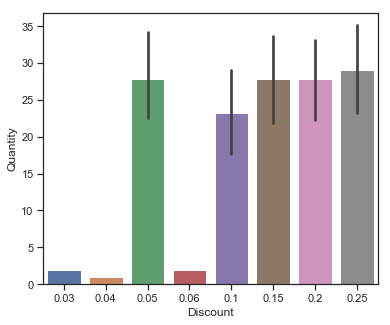

In [179]:
sns.barplot(top_unit_price.Discount, top_unit_price.Quantity)

In [180]:
bottom_unit_price = discount[discount['UnitPrice'] < 12]

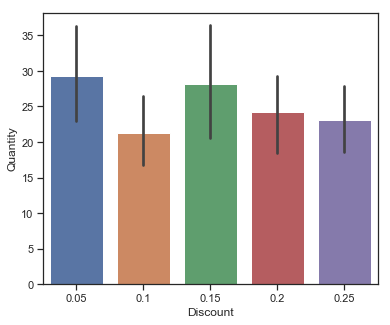

In [181]:
sns.barplot(bottom_unit_price.Discount, bottom_unit_price.Quantity)

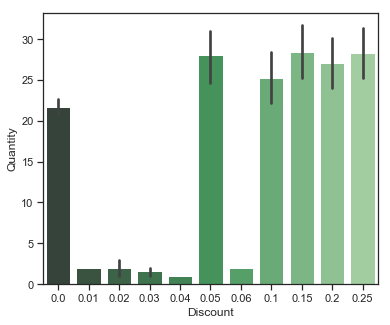

In [182]:
sns.barplot(order_details.Discount, order_details.Quantity, palette="Greens_d")

In [183]:
order_details.Quantity.describe()

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [184]:
len(order_details[order_details.Quantity > 30])/len(order_details)

0.23062645011600927

In [185]:
len(order_details[order_details.Quantity > 30])

497

In [186]:
order_details[order_details.Quantity >= 30].describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_bin
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,10659.043415,41.438495,26.733763,45.383502,0.070550,0.458755
std,238.112167,22.176242,32.320882,18.368190,0.090755,0.498657
min,10249.000000,1.000000,2.000000,30.000000,0.000000,0.000000
25%,10445.500000,23.000000,12.500000,30.000000,0.000000,0.000000
50%,10659.000000,41.000000,18.000000,40.000000,0.000000,0.000000
75%,10861.000000,60.000000,32.000000,50.000000,0.150000,1.000000
max,11075.000000,77.000000,263.500000,130.000000,0.250000,1.000000


Top Products
- sold between 30-130 units
- 497 products - 23% total products
- 2.00 min, 263.50 max
- 0-25% discount


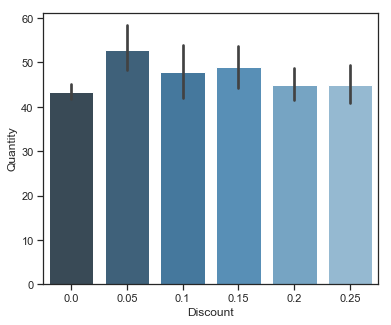

In [187]:
top_quantity = order_details[order_details.Quantity >= 30]
sns.barplot(top_quantity.Discount, top_quantity.Quantity, palette="Blues_d")

In [188]:
order_details.ProductId.mode()

0    59
dtype: int64

In [453]:
products[products.ProductId == 60.0]

,ProductId,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
59,60,Camembert Pierrot,28,4,15 - 300 g rounds,34.0,19,0,0,0


Most Popular Product Id 59
- 54 units sold
- average unit price 51.13
- average dicsount 0.048
- range from 0 - 0.25


In [189]:
order_details[order_details.ProductId == 59].describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_bin
count,54.000000,54.0,54.000000,54.000000,54.000000,54.000000
mean,10634.333333,59.0,51.129630,27.703704,0.047222,0.370370
std,237.081150,0.0,5.302354,22.964805,0.074869,0.487438
min,10255.000000,59.0,44.000000,1.000000,0.000000,0.000000
25%,10436.750000,59.0,44.000000,10.500000,0.000000,0.000000
50%,10641.000000,59.0,55.000000,24.500000,0.000000,0.000000
75%,10802.000000,59.0,55.000000,39.000000,0.050000,1.000000
max,11036.000000,59.0,55.000000,110.000000,0.250000,1.000000


In [190]:
order_details[order_details.ProductId == 59].head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_bin
23,10255/59,10255,59,44.0,30,0.00,0
53,10267/59,10267,59,44.0,70,0.15,1
73,10275/59,10275,59,44.0,6,0.05,1
79,10278/59,10278,59,44.0,15,0.00,0
136,10298/59,10298,59,44.0,30,0.25,1


In [191]:
order_details[order_details.ProductId == 59].Discount.value_counts()

0.00    34
0.05     7
0.15     6
0.20     3
0.10     2
0.25     2
Name: Discount, dtype: int64

Most were sold without any discount (34)
7 with 0.05 discount

In [192]:
customers_orders = pd.merge(customers,
                           orders,
                           on='CustomerId')

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

Text(0, 0.5, 'Freight Shipping Costs')

Text(0.5, 0, 'Customer Regions')

Text(0.5, 1.0, 'Regional Freight Shipping Costs')

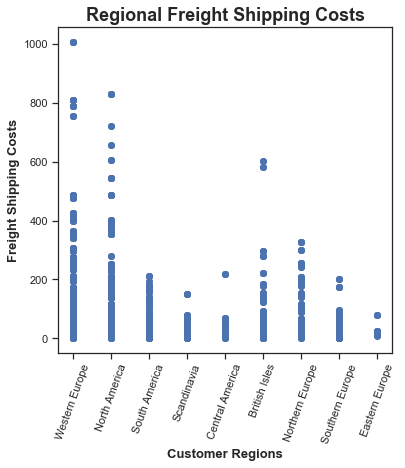

In [193]:
fig = plt.figure(figsize = (6,6))
plt.scatter(employees_orders_order_details_products_customers_suppliers.Region_Customer, employees_orders_order_details_products_customers_suppliers.Freight)
plt.xticks(rotation=70)
plt.ylabel('Freight Shipping Costs', fontsize=13, fontweight='bold')
plt.xlabel('Customer Regions', fontsize=13, fontweight='bold')
plt.title('Regional Freight Shipping Costs', fontsize=18, fontweight='bold')

In [194]:
customers_orders_order_details = pd.merge(customers_orders,
                           order_details,
                           on='OrderId')
customers_orders_order_details.head(2)

,CustomerId,CompanyName_Customer,ContactName_Customer,ContactTitle_Customer,Address_Customer,City_Customer,Region_Customer,PostalCode_Customer,Country_Customer,Phone_Customer,...,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,ProductId,UnitPrice,Quantity,Discount,Discount_bin
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,...,Berlin,Western Europe,12209,Germany,10643/28,28,45.6,15,0.25,1
1,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,...,Berlin,Western Europe,12209,Germany,10643/39,39,18.0,21,0.25,1


In [195]:
customers_orders_order_details[(customers_orders_order_details.Region_Customer == 'Western Europe') & 
                               (customers_orders_order_details.CompanyName_Customer == 'Alfreds Futterkiste')].head(2)

,CustomerId,CompanyName_Customer,ContactName_Customer,ContactTitle_Customer,Address_Customer,City_Customer,Region_Customer,PostalCode_Customer,Country_Customer,Phone_Customer,...,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,ProductId,UnitPrice,Quantity,Discount,Discount_bin
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,...,Berlin,Western Europe,12209,Germany,10643/28,28,45.6,15,0.25,1
1,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,...,Berlin,Western Europe,12209,Germany,10643/39,39,18.0,21,0.25,1


In [197]:
customers_orders_order_details_products = pd.merge(customers_orders_order_details,
                           products,
                           on=['ProductId', 'UnitPrice'])

In [262]:
discount_totals_df = order_details.copy(deep=True)

In [264]:
sum_products = []
for discount in order_details.Discount.unique():
    sum_products.append(sum(discount_totals_df[discount_totals_df.Discount == discount].Quantity))
sum_products

[28599, 4456, 5182, 4351, 4349, 4366, 4, 5, 1, 2, 2]

In [266]:
discount_sum_products_dictionary = dict(zip(order_details.Discount.unique(), sum_products))
print(discount_sum_products_dictionary)

{0.0: 28599, 0.15: 4456, 0.05: 5182, 0.2: 4351, 0.25: 4349, 0.1: 4366, 0.02: 4, 0.03: 5, 0.04: 1, 0.06: 2, 0.01: 2}


In [290]:
df_discount_sum_products = pd.DataFrame.from_dict(discount_sum_products_dictionary, orient='index').reset_index()
df_discount_sum_products.columns = ['Discount', 'Total_Products_Sold']
df_discount_sum_products.head()

,Discount,Total_Products_Sold
0,0.00,28599
1,0.15,4456
2,0.05,5182
3,0.20,4351
4,0.25,4349


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Discount Levels for Quantity of Products Sold')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Quantity')

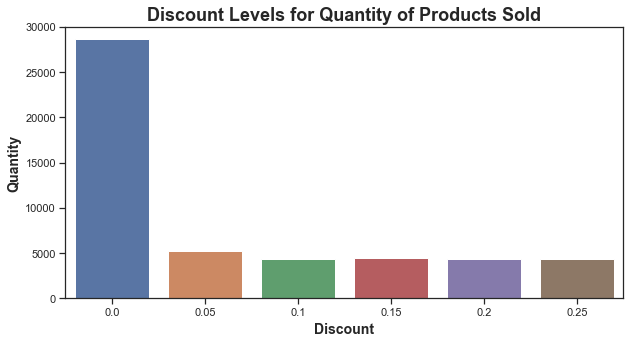

In [307]:
plt.figure(figsize=(10,5))
sns.barplot(df_discount_sum_products[df_discount_sum_products.Total_Products_Sold > 1000].Discount, df_discount_sum_products[df_discount_sum_products.Total_Products_Sold > 1000].Total_Products_Sold)
plt.title('Discount Levels for Quantity of Products Sold', fontweight='bold', fontsize=18)
plt.xlabel('Discount', fontweight='bold', fontsize=14)
plt.ylabel('Quantity', fontweight='bold', fontsize=14)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Products Sold at a Discount')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Total Products Sold')

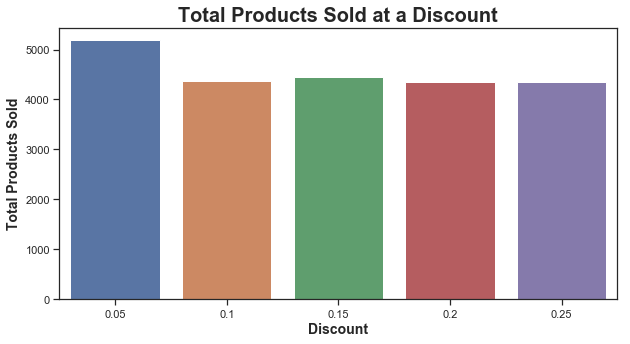

In [308]:
plt.figure(figsize=(10,5))
sns.barplot(df_discount_sum_products[(df_discount_sum_products.Discount > 0) & 
                                     (df_discount_sum_products.Total_Products_Sold > 1000)].Discount, 
            df_discount_sum_products[(df_discount_sum_products.Discount > 0) & 
                                     (df_discount_sum_products.Total_Products_Sold > 1000)].Total_Products_Sold)
plt.title('Total Products Sold at a Discount', fontweight='bold', fontsize=20)
plt.xlabel('Discount', fontweight='bold', fontsize=14)
plt.ylabel('Total Products Sold', fontweight='bold', fontsize=14)

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Discount Levels for Quantity of Products Sold')

Text(0.5, 0, 'Discount')

Text(0, 0.5, 'Quantity')

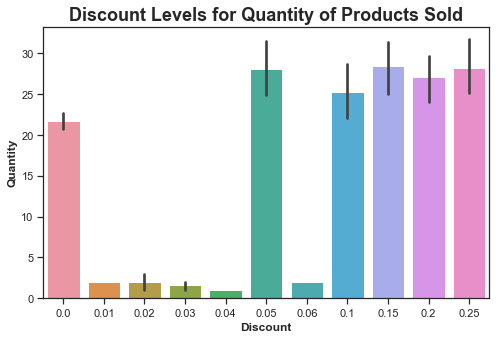

In [244]:
plt.figure(figsize=(8,5))
sns.barplot(order_details.Discount, order_details.Quantity)
plt.title('Discount Levels for Quantity of Products Sold', fontweight='bold', fontsize=18)
plt.xlabel('Discount', fontweight='bold', fontsize=12)
plt.ylabel('Quantity', fontweight='bold', fontsize=12)

### Additional analysis on employee performance
#### Choosing three of the members of the sales team - Anne, Andrew, and Michael

In [101]:
df_anne = employees_orders_order_details_products[employees_orders_order_details_products.FirstName == 'Anne']
df_andrew = employees_orders_order_details_products[employees_orders_order_details_products.FirstName == 'Andrew']
df_michael = employees_orders_order_details_products[employees_orders_order_details_products.FirstName == 'Michael']

__Anne's Sales Strategy and Performance__

In [102]:
df_anne.Discount_bin.value_counts()

0    51
1    34
Name: Discount_bin, dtype: int64

In [103]:
df_anne.Discount.value_counts()

0.00    51
0.15    13
0.05     9
0.25     8
0.10     3
0.20     1
Name: Discount, dtype: int64

In [104]:
print('Anne Performance')
print('Total Sales: $', round(sum(df_anne.Total_Sale), 2))
print('% of Total Sales:', round(round(sum(df_anne.Total_Sale), 2)/
                                 (round(sum(employees_orders_order_details_products.Total_Sale), 2)), 2), '%')
print('Largest Sale: $', df_anne.Total_Sale.max())
print('% of orders discounted:', (34/85)*100, '%')
print('Most popular level of discount: 15%')

Anne Performance
Total Sales: $ 64941.57
% of Total Sales: 0.07 %
Largest Sale: $ 10540.0
% of orders discounted: 40.0 %
Most popular level of discount: 15%


Anne offered discounts on 34 of her 85 orders, 40% of her total. The 15% discount level was her most frequently used followed by 5% and 25% close behind. So that leaves 60% of her orders sold at full price.

__Andrew's Sales Strategy and Performance__

In [105]:
df_andrew.Discount_bin.value_counts()

0    127
1     56
Name: Discount_bin, dtype: int64

In [106]:
df_andrew.Discount.value_counts()

0.00    127
0.15     17
0.05     11
0.10     10
0.20     10
0.25      8
Name: Discount, dtype: int64

In [107]:
print('Andrew Performance')
print('Total Sales: $', round(sum(df_andrew.Total_Sale), 2))
print('% of Total Sales:', round(round(sum(df_andrew.Total_Sale), 2)/
                                 (round(sum(employees_orders_order_details_products.Total_Sale), 2)), 2), '%')
print('Largest Sale:$', round(df_andrew.Total_Sale.max(), 2))
print('% of orders discounted:', round((56/183)*100, 2), '%')
print('Most popular level of discount: 15%')

Andrew Performance
Total Sales: $ 137291.92
% of Total Sales: 0.15 %
Largest Sale:$ 15019.5
% of orders discounted: 30.6 %
Most popular level of discount: 15%


Anne offered discounts on 56 of his 127 orders, 31% of his total. The 15% discount level was also his most frequently used followed by 5%, 10%, and 20% close behind. So that leaves 69%% of his orders sold at full price.

__Michael's Sales Strategy and Performance__

In [108]:
df_michael.Discount_bin.value_counts()

0    67
1    47
Name: Discount_bin, dtype: int64

In [109]:
df_michael.Discount.value_counts()

0.00    67
0.05    13
0.10    13
0.20     9
0.15     7
0.25     5
Name: Discount, dtype: int64

In [110]:
print('Michael Performance')
print('Total Sales: $', round(sum(df_michael.Total_Sale), 2))
print('% of Total Sales:', round(round(sum(df_michael.Total_Sale), 2)/
                                 (round(sum(employees_orders_order_details_products.Total_Sale), 2)), 2), '%')
print('Largest Sale: $', round(df_michael.Total_Sale.max(), 2))
print('% of orders discounted:', round((47/114)*100, 2),  '%')
print('Most popular level of discount: 5% and 10%')

Michael Performance
Total Sales: $ 53371.08
% of Total Sales: 0.06 %
Largest Sale: $ 4456.44
% of orders discounted: 41.23 %
Most popular level of discount: 5% and 10%


Michael offered discounts on 47 of his 67 orders, 41% of his total. The 5% discount level was his most frequently used followed by 5% and 10% close behind. So that leaves 59% of his orders sold at full price.

### __Summary of Employee Performance__

In [111]:
employees_list_anne_andrew_michael = [df_anne, df_andrew, df_michael]
combined_employees = pd.concat(employees_list_anne_andrew_michael)

Text(0.5, 1.0, 'Employee Performance: Total Sale and Quantity Sold')

Text(0, 0.5, 'Total Sale')

Text(0, 0.5, 'Quantity')

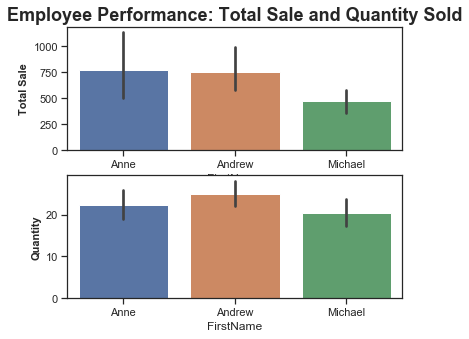

In [239]:
plt.subplot(2, 1, 1)
plt.title('Employee Performance: Total Sale and Quantity Sold', fontweight='bold', fontsize=18)
sns.barplot(combined_employees.FirstName, combined_employees.Total_Sale)
plt.ylabel('Total Sale', fontweight='bold', fontsize=11)
plt.subplot(2, 1, 2)
sns.barplot(combined_employees.FirstName, combined_employees.Quantity)
plt.ylabel('Quantity', fontweight='bold', fontsize=11)
plt.show()

In [200]:
customers_orders_order_details_products.CompanyName.unique()

AttributeError: 'DataFrame' object has no attribute 'CompanyName'

In [201]:
len(customers_orders_order_details_products.CompanyName.unique())

AttributeError: 'DataFrame' object has no attribute 'CompanyName'

In [ ]:
customers_orders_order_details_products.Region.unique()

In [ ]:
customers_orders_order_details_products_1.Country.unique()

#### Customer Analysis
There are a total of 84 different customers represented across 9 different regions and 21 countries across the globe.

In [ ]:
customers_orders_order_details_products_1['Total_Sale'] = (customers_orders_order_details_products_1.UnitPrice 
* customers_orders_order_details_products_1.Quantity * (1-customers_orders_order_details_products_1.Discount))

In [ ]:
for customer in customers_orders_order_details_products_1.CustomerId.unique():
      print(customer,' Total Sale: $', round(sum(customers_orders_order_details_products_1[
        customers_orders_order_details_products_1.CustomerId == customer].Total_Sale), 2))

#### Highest Total Sale - Customer
- Company: QUICK-Stop
- CustomerId: QUICK
- ContactName: Horst Kloss
- Region: Western Europe
- Country: Germany

In [ ]:
QUICK_customer = customers_orders_order_details_products_1[customers_orders_order_details_products_1.CustomerId 
                                                           == 'QUICK']

In [ ]:
sum(QUICK_customer.Total_Sale)

In [ ]:
QUICK_customer.OrderDate.unique()

In [ ]:
suppliers.columns = ['SupplierId', 'CompanyName', 'ContactName', 'ContactTitle', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'Phone', 'Fax', 'HomePage']

Employees

In [ ]:
employees.head(1)

In [ ]:
emp_territories.head()

In [ ]:
employ_emp_terr = pd.merge(employees, 
                           emp_territories,
                           on='EmployeeId')

In [ ]:
orders.columns = ['OrderId', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']

In [ ]:
employees_orders = pd.merge(employees, 
         orders,
        on='EmployeeId')

In [ ]:
employees_orders.describe()

In [ ]:
employees_orders_order_details = pd.merge(employees_orders, 
         order_details,
        on='OrderId')

In [ ]:
employees_orders_order_details.EmployeeId.value_counts()

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(employees_orders_order_details.FirstName, employees_orders_order_details.Quantity)

In [ ]:
products.columns

In [ ]:
products.columns = ['ProductId', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued']
products.columns

In [ ]:
employees_orders_order_details.columns

In [ ]:
employees_orders_order_details_products = pd.merge(employees_orders_order_details, 
         products,
        on=['ProductId', 'UnitPrice'])

In [ ]:
employees_orders_order_details_products.head(2)

In [ ]:
employees_orders_order_details_products['Total_Sale'] = (employees_orders_order_details_products.UnitPrice 
* employees_orders_order_details_products.Quantity * (1-employees_orders_order_details_products.Discount))

In [ ]:
employees_orders_order_details_products.Total_Sale.head()

In [ ]:
sns.barplot(employees_orders_order_details_products.FirstName, employees_orders_order_details_products.Total_Sale)

In [ ]:
employees_orders_order_details_products.head(1)

In [ ]:
categories.columns = ['CategoryId', 'CategoryName', 'Description']

In [ ]:
employees_orders_order_details_products_categories = pd.merge(employees_orders_order_details_products,
                                                             categories,
                                                             on='CategoryId')

In [ ]:
employees_orders_order_details_products_categories.head(1)

In [ ]:
sns.barplot(employees_orders_order_details_products_categories.Total_Sale, 
            employees_orders_order_details_products_categories.CategoryName)

In [ ]:
employees_orders_order_details_products_categories.ProductName.value_counts()

In [ ]:
employees_orders_order_details_products_categories[employees_orders_order_details_products_categories.ProductName 
                                                   == 'Zaanse koeken']

In [ ]:
product_names = employees_orders_order_details_products_categories.ProductName.unique()
total_sale_list = []
for product in product_names:
    total_sale_list.append(round(sum(employees_orders_order_details_products_categories[
        employees_orders_order_details_products_categories.ProductName == product].Total_Sale), 2))

keys = product_names
values = total_sale_list
prod_total_sale_dictionary = dict(zip(keys,values))
prod_total_sale_dictionary

In [ ]:
prod_total_sale_dictionary = sorted(prod_total_sale_dictionary.items(), key=lambda x: x[1])
prod_total_sale_dictionary

In [ ]:
prod_total_sale_df = pd.DataFrame.from_dict(prod_total_sale_dictionary)
prod_total_sale_df.columns = ['ProductName', 'TotalSale']
prod_total_sale_df[prod_total_sale_df.TotalSale > 12562]

In [ ]:
plot_1 = sns.barplot(prod_total_sale_df[prod_total_sale_df.TotalSale > 33300].ProductName, 
            prod_total_sale_df[prod_total_sale_df.TotalSale > 33300].TotalSale)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=70)

In [ ]:
prod_total_sale_df.describe()

In [ ]:
round(sum(employees_orders_order_details_products_categories[
    employees_orders_order_details_products_categories.ProductName == 'Rhönbräu Klosterbier'].Total_Sale), 2)

In [ ]:
round(sum(employees_orders_order_details_products_categories[
    employees_orders_order_details_products_categories.ProductName == 'Raclette Courdavault'].Total_Sale), 2) 